Periodogram peaks above a power of 0.25: []
mass ratio is  0.359284288715 +/- 0.000570881285791


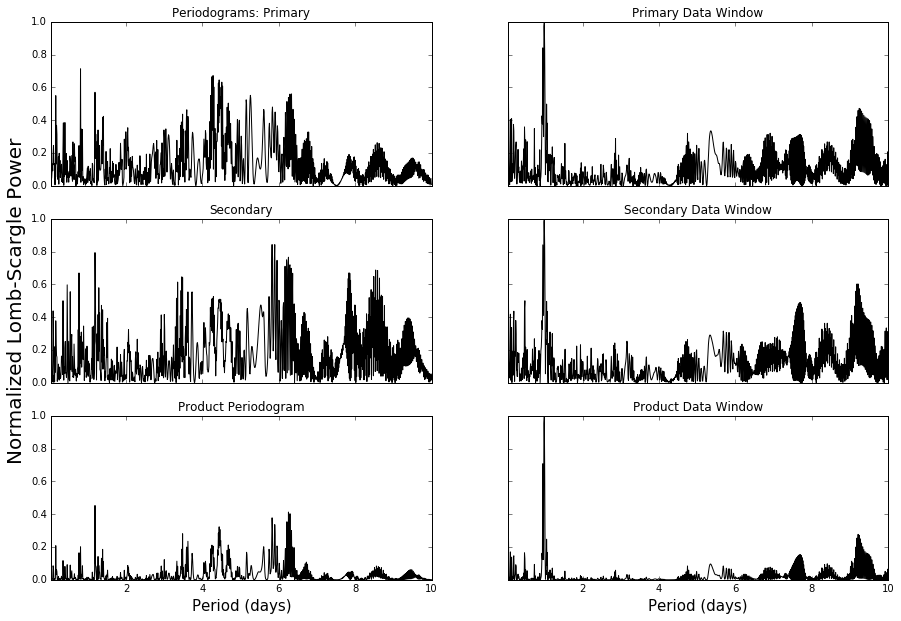

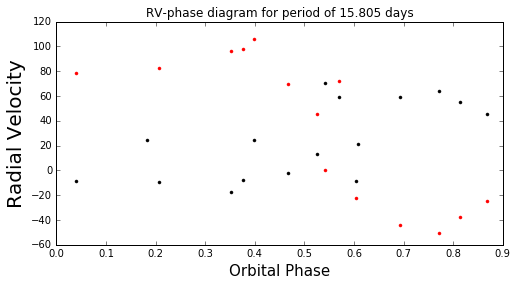

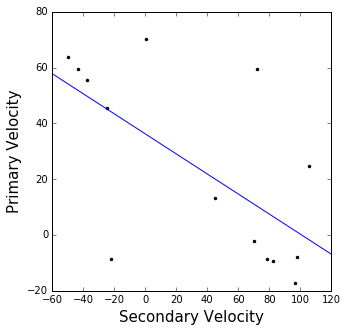

In [12]:
#import-libraries-and-data---------------------------------------------------------------------------------------#
import time
import emcee
import corner
import numpy as np
import functions as f
from scipy import stats
from matplotlib import pyplot as plt
from scipy.signal import lombscargle
from scipy.optimize import curve_fit
%matplotlib inline
filename     = 'V1481.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))#, max_rows=11)

#use only first 11 data points to use ESO data, last 5 for APOGEE data

#define-variables------------------------------------------------------------------------------------------------#

JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD
samples      = 1000
max_period   = 10

#define-function-------------------------------------------------------------------------------------------------#

periodogram = f.periodogram
dataWindow  = f.dataWindow
maxima      = f.maxima
phases      = f.phases
massRatio   = f.massRatio
adjustment  = f.adjustment
RV          = f.RV
residuals   = f.residuals
constraints = f.constraints
alteredRV   = f.alteredRV

#now-do-things!--------------------------------------------------------------------------------------------------#

#check RV measurements for the need to be adjusted and adjust them if so
for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break
        
# plot the results
x, y  = periodogram(JDp, RVp, samples, max_period)
y2    = periodogram(JDs, RVs, samples, max_period)[1]
y3,y4 = dataWindow(JDp, samples, max_period)[1], dataWindow(JDs, samples, max_period)[1]

fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')
ax1.plot(x, y, 'k')
ax1.set_title('Periodograms: Primary')
ax1.set_xlim(1/24, max_period)
ax4.set_xlim(1/24, max_period)
ax2.plot(x, y2, 'k')
ax2.set_title('Secondary')
ax3.plot(x, y*y2, 'k')
ax3.set_title('Product Periodogram')
ax4.plot(x, y3, 'k')
ax4.set_title('Primary Data Window')
ax5.plot(x, y4, 'k')
ax5.set_title('Secondary Data Window')
ax6.plot(x, y3*y4, 'k')
ax6.set_title('Product Data Window')
ax3.set_xlabel('Period (days)', size='15')
ax6.set_xlabel('Period (days)', size='15')
ax2.set_ylabel('Normalized Lomb-Scargle Power', size='20')
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.savefig(filename + ' periodogram.pdf')
print('Periodogram peaks above a power of 0.25:',maxima(0.8, x, y, y2))

fig, ((ax1)) = plt.subplots(1,1, sharex='col', sharey='row')
ax1.plot(phases(maxima(0.3, x, y, y2)[3], 0, JDp), RVp, 'k.')
ax1.plot(phases(maxima(0.3, x, y, y2)[3], 0, JDs), RVs, 'r.')
ax1.set_title('RV-phase diagram for period of 15.805 days')
ax1.set_xlabel('Orbital Phase', size='15')
ax1.set_ylabel('Radial Velocity', size='20')
#fig.set_figheight(12)
fig.set_figwidth(8)
#plt.savefig(filename + ' RV-phase diagram.pdf')

mass_ratio, intercept, r_squared, standard_error, slope_error = massRatio(RVs,RVp, system)
p = [datum[1] for datum in system if not np.isnan(datum[1]+datum[2])]
s = [datum[2] for datum in system if not np.isnan(datum[1]+datum[2])]
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(s, p, 'k.')
ax.plot(np.array([-60, 120]), -mass_ratio*np.array([-60, 120])+intercept)
ax.set_ylabel('Primary Velocity', size='15')
ax.set_xlabel('Secondary Velocity', size='15')
print('mass ratio is ', mass_ratio, "+/-", slope_error)

(2456606, 2456637)

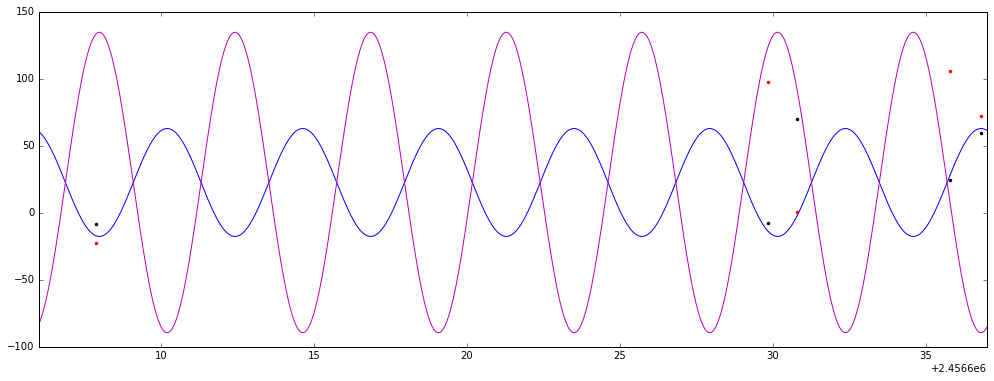

In [13]:
#parameters according to S. Messina et al (2016)
parameters = -40.3, 0, 0, 30, 4.433, 22.7

x = np.linspace(2453640, 2456700, num = 100000)

primary, secondary = RV(x, mass_ratio, parameters)
plt.figure(figsize=(17,6))
plt.plot(x, primary)
plt.plot(x, secondary, 'm')

plt.plot(JDp, RVp, 'k.')
plt.plot(JDs, RVs, 'r.')
#plt.xlim(2453657, 2453756) #uncomment for veiw of ESO points
plt.xlim(2456606, 2456637) #uncomment for view of APOGEE points